In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import pandas as pd
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ndcg_score
from tqdm import tqdm 
from datetime import datetime
from model_trainer.entities import ANOMALY_ARCHIVE_ENTITIES, ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY
from pprint import pprint
from joblib import Parallel, delayed
from evaluation.evaluation import get_stats_dict, get_aggregate_stats, get_anomaly_scores_labels, get_aggregate_stats_concat

import sys
sys.path.append('/home/ubuntu/PyMAD/')
from src.pymad.evaluation.numpy import adjusted_precision_recall_f1_auc

In [3]:
# Path to saved ranking objects
dataset = 'anomaly_archive'
metric = 'influence'
evaluation_metric = 'Best F-1' # 'PR-AUC' 'Best F-1'
save_dir = r'/home/ubuntu/efs/results/'
overwrite = False
n_jobs = 8

In [4]:
stats = get_stats_dict(dataset=dataset, metric=metric, evaluation_metric=evaluation_metric, overwrite=overwrite, n_jobs=n_jobs, save_dir=save_dir, verbose=False)

# Pop None dict keys
ks = list(stats.keys())
for k in ks:
    if stats[k] is None: stats.pop(k)

In [5]:
# Look at all anomaly archive data families
data_families = ['All Entities']
data_families.extend(sorted(list(set(list(ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY.values())))))
pprint(f'Data families: {data_families}') 

("Data families: ['All Entities', 'Acceleration Sensor Data', 'Accelerometer', "
 "'Air Temperature', 'Atrial Blood Pressure (ABP)', 'Electrocardiogram (ECG) "
 "Arrhythmia', 'Gait', 'Insect Electrical Penetration Graph (EPG)', 'NASA "
 "Data', 'Pig Atrial Blood Pressure', 'Power Demand', 'Respiration Rate "
 "(RESP)']")


### Aggregate Results per Entity

In [6]:
aggregate_stats = {}
for i, data_family in tqdm(enumerate(data_families)):
    if data_family == 'All Entities':
        aggregate_stats[data_family] = get_aggregate_stats(stats, evaluation_metric='Best F-1')    
        continue
    
    entities_in_data_family = [i for i in stats.keys() if ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY[i] == data_family]
    values_in_data_familiy = [stats[i] for i in entities_in_data_family]
    stats_data_family = dict(zip(entities_in_data_family, values_in_data_familiy))
    aggregate_stats[data_family] = get_aggregate_stats(stats_data_family, evaluation_metric='Best F-1')

12it [00:00, 657.17it/s]


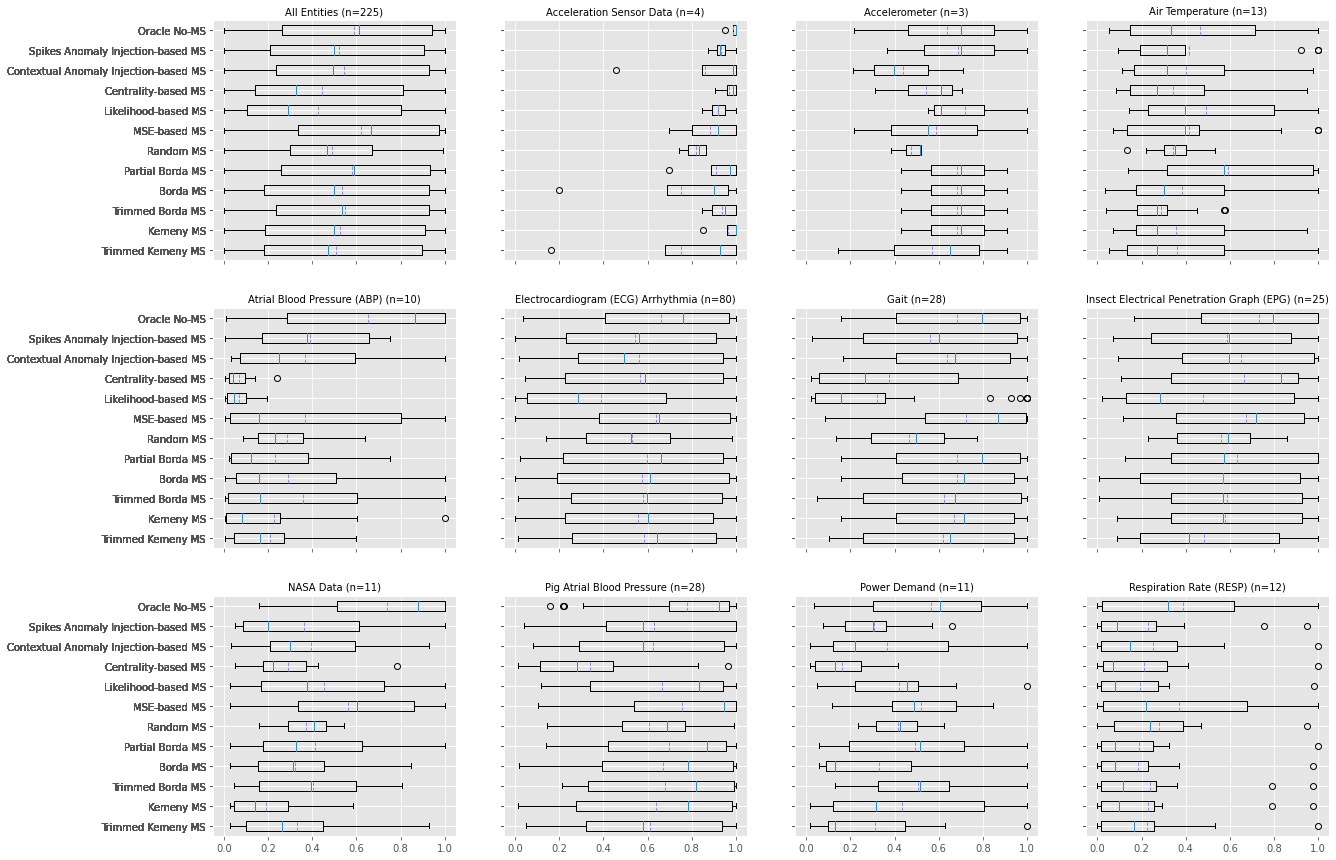

In [7]:
plt.style.use('ggplot')
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True, sharex=True)
axes = axes.flatten()

for i, data_family in enumerate(data_families):
    axes[i].set_title(f"{data_family} (n={len(aggregate_stats[data_family]['Oracle No-MS/Oracle MS'])})", fontsize=10)    
    _ = axes[i].boxplot([i[1] for i in aggregate_stats[data_family].items() if '/' in i[0]], 
                            vert=False, 
                            bootstrap=10000,
                            showmeans=True,
                            meanline=True, 
                            labels = [i[0].split('/')[0] for i in aggregate_stats[data_family].items() if '/' in i[0]])

plt.savefig(f"box_plot_{dataset}_{metric}_{evaluation_metric}_per_entity_{datetime.today().strftime(r'%H-%M-%m-%d-%Y')}.pdf", bbox_inches='tight')
plt.show()

In [8]:
results_table = {}
for data_family in aggregate_stats.keys():
    results_table[data_family] = {}
    for s in aggregate_stats[data_family]:
        # results_table[data_family][s] = {}
        # results_table[data_family][s][f'Mean'] = np.mean(aggregate_stats[data_family][s])
        # results_table[data_family][s][f'Std'] = np.std(aggregate_stats[data_family][s])
        # results_table[data_family][s][f'Median'] = np.median(aggregate_stats[data_family][s])
        # results_table[data_family][s][f'IQR'] = np.quantile(a=aggregate_stats[data_family][s], q=0.75) - np.quantile(a=aggregate_stats[data_family][s], q=0.25)
        results_table[data_family][s] = f"({np.around(np.mean(aggregate_stats[data_family][s]), 2)}, {np.around(np.std(aggregate_stats[data_family][s]), 2)}), ({np.around(np.median(aggregate_stats[data_family][s]), 2)}, {np.around(np.quantile(a=aggregate_stats[data_family][s], q=0.75) - np.quantile(a=aggregate_stats[data_family][s], q=0.25), 2)})"
        
results_table = pd.DataFrame(results_table)

In [9]:
results_table

,All Entities,Acceleration Sensor Data,Accelerometer,Air Temperature,Atrial Blood Pressure (ABP),Electrocardiogram (ECG) Arrhythmia,Gait,Insect Electrical Penetration Graph (EPG),NASA Data,Pig Atrial Blood Pressure,Power Demand,Respiration Rate (RESP)
Trimmed Kemeny MS,"(0.4, 0.36), (0.29, 0.71)","(0.75, 0.35), (0.93, 0.32)","(0.22, 0.1), (0.24, 0.12)","(0.21, 0.21), (0.11, 0.3)","(0.15, 0.19), (0.09, 0.13)","(0.42, 0.37), (0.35, 0.71)","(0.56, 0.36), (0.62, 0.72)","(0.36, 0.34), (0.24, 0.38)","(0.22, 0.25), (0.13, 0.33)","(0.59, 0.34), (0.58, 0.63)","(0.27, 0.28), (0.09, 0.41)","(0.09, 0.28), (0.0, 0.01)"
Kemeny MS,"(0.41, 0.38), (0.29, 0.77)","(0.95, 0.06), (0.97, 0.09)","(0.28, 0.03), (0.26, 0.04)","(0.22, 0.21), (0.13, 0.28)","(0.17, 0.3), (0.01, 0.13)","(0.39, 0.37), (0.23, 0.68)","(0.6, 0.33), (0.69, 0.57)","(0.46, 0.39), (0.33, 0.81)","(0.1, 0.12), (0.05, 0.15)","(0.62, 0.37), (0.78, 0.72)","(0.39, 0.37), (0.23, 0.75)","(0.08, 0.27), (0.0, 0.0)"
Trimmed Borda MS,"(0.41, 0.37), (0.29, 0.76)","(0.92, 0.08), (0.92, 0.15)","(0.28, 0.03), (0.26, 0.04)","(0.18, 0.18), (0.11, 0.28)","(0.22, 0.32), (0.04, 0.3)","(0.39, 0.37), (0.23, 0.68)","(0.54, 0.35), (0.59, 0.69)","(0.46, 0.39), (0.33, 0.76)","(0.19, 0.2), (0.1, 0.24)","(0.65, 0.33), (0.74, 0.65)","(0.37, 0.24), (0.44, 0.41)","(0.08, 0.27), (0.0, 0.01)"
Borda MS,"(0.42, 0.38), (0.31, 0.81)","(0.73, 0.32), (0.87, 0.23)","(0.28, 0.03), (0.26, 0.04)","(0.26, 0.3), (0.07, 0.43)","(0.21, 0.32), (0.04, 0.3)","(0.42, 0.39), (0.23, 0.84)","(0.6, 0.32), (0.69, 0.57)","(0.44, 0.38), (0.29, 0.76)","(0.21, 0.2), (0.17, 0.32)","(0.64, 0.34), (0.71, 0.63)","(0.3, 0.31), (0.09, 0.42)","(0.08, 0.27), (0.0, 0.0)"
Partial Borda MS,"(0.45, 0.37), (0.37, 0.78)","(0.9, 0.12), (0.94, 0.16)","(0.28, 0.03), (0.26, 0.04)","(0.29, 0.18), (0.32, 0.2)","(0.16, 0.21), (0.05, 0.31)","(0.43, 0.38), (0.4, 0.76)","(0.61, 0.33), (0.77, 0.57)","(0.49, 0.39), (0.33, 0.84)","(0.29, 0.34), (0.1, 0.47)","(0.68, 0.34), (0.87, 0.59)","(0.43, 0.31), (0.48, 0.54)","(0.09, 0.28), (0.0, 0.0)"
Oracle MS,"(0.68, 0.37), (0.87, 0.68)","(0.98, 0.03), (1.0, 0.02)","(0.45, 0.11), (0.37, 0.12)","(0.57, 0.38), (0.63, 0.83)","(0.52, 0.36), (0.57, 0.65)","(0.64, 0.37), (0.82, 0.73)","(0.83, 0.26), (0.95, 0.13)","(0.73, 0.34), (0.9, 0.35)","(0.55, 0.37), (0.71, 0.66)","(0.92, 0.18), (1.0, 0.01)","(0.72, 0.34), (0.94, 0.52)","(0.2, 0.37), (0.0, 0.12)"
Random MS,"(0.38, 0.29), (0.32, 0.51)","(0.81, 0.06), (0.81, 0.12)","(0.2, 0.02), (0.19, 0.02)","(0.21, 0.16), (0.27, 0.29)","(0.19, 0.22), (0.12, 0.18)","(0.38, 0.31), (0.3, 0.53)","(0.42, 0.22), (0.47, 0.35)","(0.43, 0.29), (0.42, 0.5)","(0.24, 0.19), (0.26, 0.33)","(0.58, 0.27), (0.69, 0.45)","(0.34, 0.2), (0.4, 0.32)","(0.1, 0.26), (0.0, 0.02)"
MSE-based MS,"(0.46, 0.37), (0.37, 0.75)","(0.87, 0.13), (0.89, 0.24)","(0.23, 0.1), (0.2, 0.12)","(0.23, 0.28), (0.13, 0.21)","(0.24, 0.38), (0.08, 0.11)","(0.43, 0.36), (0.32, 0.65)","(0.64, 0.32), (0.75, 0.48)","(0.51, 0.37), (0.42, 0.7)","(0.36, 0.33), (0.25, 0.55)","(0.71, 0.34), (0.92, 0.64)","(0.4, 0.24), (0.43, 0.31)","(0.12, 0.29), (0.0, 0.01)"
Likelihood-based MS,"(0.32, 0.36), (0.14, 0.61)","(0.91, 0.06), (0.89, 0.1)","(0.31, 0.08), (0.37, 0.08)","(0.26, 0.28), (0.11, 0.19)","(0.05, 0.06), (0.02, 0.09)","(0.24, 0.31), (0.1, 0.31)","(0.28, 0.34), (0.14, 0.26)","(0.4, 0.41), (0.14, 0.82)","(0.35, 0.38), (0.2, 0.57)","(0.64, 0.34), (0.79, 0.68)","(0.38, 0.29), (0.43, 0.37)","(0.09, 0.27), (0.0, 0.0)"
Centrality-based MS,"(0.34, 0.35), (0.17, 0.61)","(0.96, 0.04), (0.96, 0.09)","(0.22, 0.03), (0.22, 0.04)","(0.22, 0.22), (0.12, 0.38)","(0.04, 0.05), (0.02, 0.02)","(0.4, 0.38), (0.2, 0.81)","(0.34, 0.33), (0.18, 0.63)","(0.54, 0.38), (0.67, 0.8)","(0.19, 0.21), (0.17, 0.23)","(0.33, 0.27), (0.28, 0.35)","(0.12, 0.13), (0.05, 0.13)","(0.09, 0.28), (0.0, 0.0)"


### Aggregate Results with Concatenated Entities

In [5]:
anomaly_scores_all_entities, anomaly_labels_all_entities = get_anomaly_scores_labels(save_dir, dataset)

  3%|▎         | 7/229 [00:01<00:27,  8.13it/s]

Fewer than 19 models trained on 128_UCR_Anomaly_GP711MarkerLFM5z2! Skipping...


 71%|███████   | 162/229 [00:11<00:03, 18.91it/s]

Fewer than 19 models trained on 083_UCR_Anomaly_DISTORTEDresperation9! Skipping...


 76%|███████▌  | 173/229 [00:11<00:03, 18.44it/s]

Fewer than 19 models trained on 131_UCR_Anomaly_GP711MarkerLFM5z5! Skipping...


100%|█████████▉| 228/229 [00:15<00:00, 13.03it/s]

Fewer than 19 models trained on 076_UCR_Anomaly_DISTORTEDresperation10! Skipping...


100%|██████████| 229/229 [00:15<00:00, 14.60it/s]


In [6]:
n_splits = 5
random_state = 0

aggregate_stats = {}
for i, data_family in tqdm(enumerate(data_families)):
    if data_family == 'All Entities': 
        aggregate_stats[data_family] = get_aggregate_stats_concat(stats, anomaly_scores_all_entities, anomaly_labels_all_entities, n_splits=n_splits, random_state=random_state)
    
    entities_in_data_family = [i for i in stats.keys() if ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY[i] == data_family]
    values_in_data_familiy = [stats[i] for i in entities_in_data_family]
    stats_data_family = dict(zip(entities_in_data_family, values_in_data_familiy))
    
    _n_splits = min(n_splits, len(entities_in_data_family))
    aggregate_stats[data_family] = get_aggregate_stats_concat(stats, anomaly_scores_all_entities, anomaly_labels_all_entities, 
                                        evaluation_metric=evaluation_metric, n_splits=n_splits, random_state=random_state)

0it [00:00, ?it/s]

4


4it [00:25,  6.40s/it]
2it [00:25, 12.80s/it]

3


3it [00:07,  2.56s/it]
3it [00:33, 10.67s/it]

5


5it [00:15,  3.19s/it]
4it [00:49, 12.65s/it]

5


5it [04:48, 57.73s/it]
5it [05:37, 108.61s/it]

5


5it [15:59, 191.93s/it]
6it [21:37, 391.05s/it]

5


5it [03:37, 43.52s/it]
7it [25:15, 335.27s/it]

5


5it [02:31, 30.39s/it]
8it [27:47, 277.56s/it]

5


5it [00:25,  5.00s/it]
9it [28:12, 199.22s/it]

5


5it [04:23, 52.77s/it]
10it [32:36, 219.07s/it]

5


5it [01:25, 17.06s/it]
11it [34:01, 178.29s/it]

5


5it [07:49, 93.94s/it]
12it [41:51, 209.25s/it]


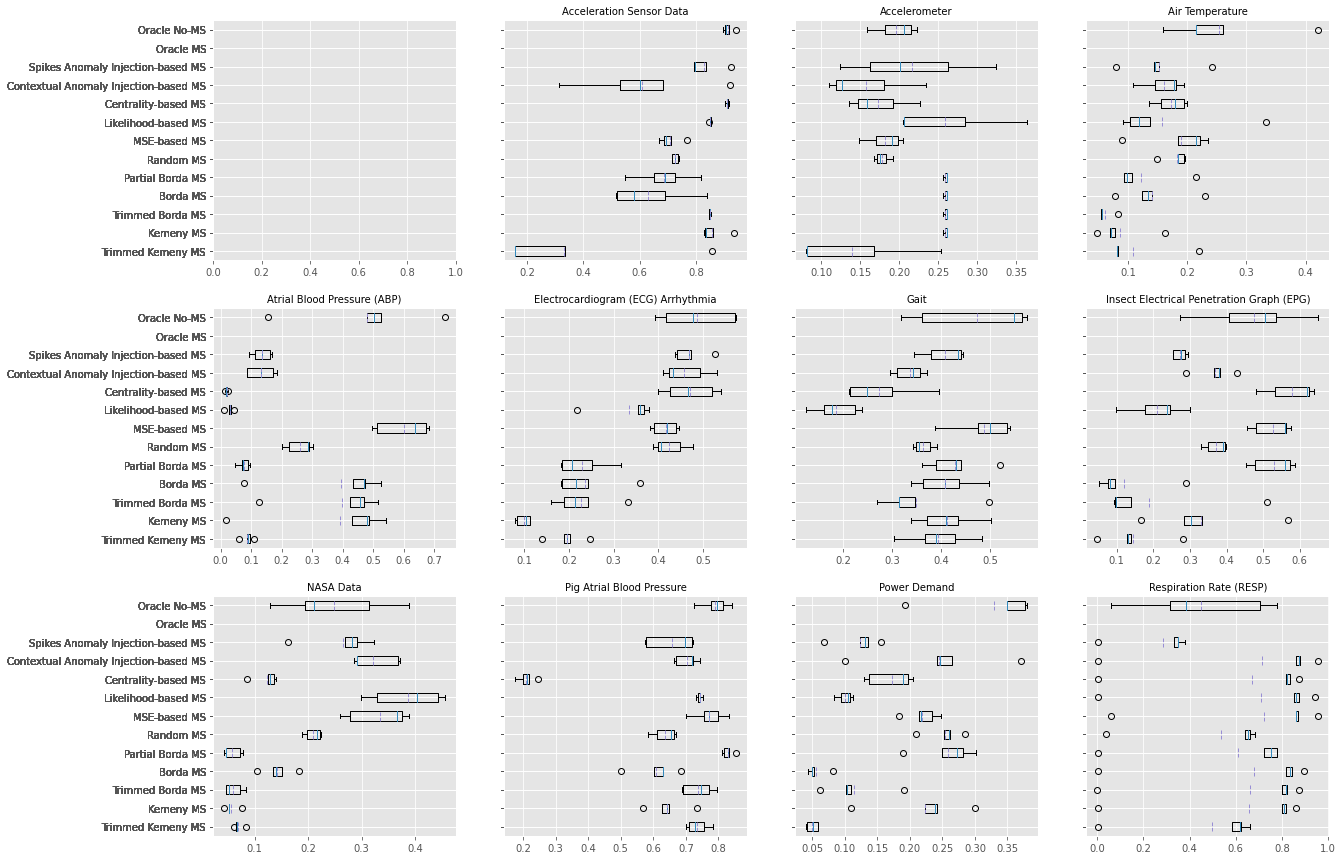

In [22]:
plt.style.use('ggplot')
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True, sharex=False)
axes = axes.flatten()

for i, data_family in enumerate(data_families):
    if data_family == 'All Entities': continue
    axes[i].set_title(f"{data_family}", fontsize=10)    
    _ = axes[i].boxplot(aggregate_stats[data_family].values(), 
                            vert=False, 
                            bootstrap=10000,
                            showmeans=True,
                            meanline=True, 
                            labels = aggregate_stats[data_family].keys())

plt.savefig(f"box_plot_{dataset}_{metric}_{evaluation_metric}_concatenated_{datetime.today().strftime(r'%H-%M-%m-%d-%Y')}.pdf", bbox_inches='tight')
plt.show()

In [15]:
results_table = {}
for data_family in aggregate_stats.keys():
    if data_family == 'All Entities': continue
    
    results_table[data_family] = {}
    for s in aggregate_stats[data_family]:
        if 'Oracle MS' == s: continue
        # results_table[data_family][s] = {}
        # results_table[data_family][s][f'Mean'] = np.mean(aggregate_stats[data_family][s])
        # results_table[data_family][s][f'Std'] = np.std(aggregate_stats[data_family][s])
        # results_table[data_family][s][f'Median'] = np.median(aggregate_stats[data_family][s])
        # results_table[data_family][s][f'IQR'] = np.quantile(a=aggregate_stats[data_family][s], q=0.75) - np.quantile(a=aggregate_stats[data_family][s], q=0.25)
        results_table[data_family][s] = f"({np.around(np.mean(aggregate_stats[data_family][s]), 2)}, {np.around(np.std(aggregate_stats[data_family][s]), 2)}), ({np.around(np.median(aggregate_stats[data_family][s]), 2)}, {np.around(np.quantile(a=aggregate_stats[data_family][s], q=0.75) - np.quantile(a=aggregate_stats[data_family][s], q=0.25), 2)})"
        
results_table = pd.DataFrame(results_table)

In [16]:
results_table

,Acceleration Sensor Data,Accelerometer,Air Temperature,Atrial Blood Pressure (ABP),Electrocardiogram (ECG) Arrhythmia,Gait,Insect Electrical Penetration Graph (EPG),NASA Data,Pig Atrial Blood Pressure,Power Demand,Respiration Rate (RESP)
Trimmed Kemeny MS,"(0.33, 0.3), (0.16, 0.18)","(0.14, 0.08), (0.08, 0.09)","(0.11, 0.06), (0.08, 0.0)","(0.09, 0.02), (0.09, 0.01)","(0.19, 0.03), (0.2, 0.02)","(0.39, 0.06), (0.39, 0.06)","(0.15, 0.08), (0.13, 0.01)","(0.07, 0.01), (0.07, 0.0)","(0.74, 0.03), (0.73, 0.05)","(0.05, 0.01), (0.05, 0.02)","(0.5, 0.25), (0.62, 0.04)"
Kemeny MS,"(0.86, 0.04), (0.83, 0.03)","(0.26, 0.0), (0.26, 0.0)","(0.09, 0.04), (0.07, 0.01)","(0.39, 0.19), (0.48, 0.06)","(0.1, 0.01), (0.1, 0.03)","(0.41, 0.06), (0.41, 0.06)","(0.33, 0.13), (0.3, 0.05)","(0.05, 0.01), (0.05, 0.0)","(0.64, 0.05), (0.64, 0.02)","(0.22, 0.06), (0.24, 0.02)","(0.66, 0.33), (0.81, 0.02)"
Trimmed Borda MS,"(0.85, 0.0), (0.85, 0.0)","(0.26, 0.0), (0.26, 0.0)","(0.06, 0.01), (0.06, 0.0)","(0.4, 0.14), (0.46, 0.04)","(0.23, 0.06), (0.21, 0.05)","(0.35, 0.08), (0.31, 0.03)","(0.19, 0.16), (0.1, 0.04)","(0.06, 0.02), (0.05, 0.03)","(0.74, 0.04), (0.75, 0.08)","(0.11, 0.04), (0.1, 0.01)","(0.66, 0.33), (0.82, 0.02)"
Borda MS,"(0.63, 0.13), (0.58, 0.17)","(0.26, 0.0), (0.26, 0.0)","(0.14, 0.05), (0.13, 0.02)","(0.4, 0.16), (0.47, 0.04)","(0.24, 0.06), (0.22, 0.06)","(0.41, 0.06), (0.41, 0.07)","(0.12, 0.09), (0.08, 0.02)","(0.14, 0.03), (0.14, 0.02)","(0.61, 0.06), (0.63, 0.03)","(0.06, 0.01), (0.05, 0.0)","(0.68, 0.34), (0.84, 0.03)"
Partial Borda MS,"(0.69, 0.1), (0.69, 0.07)","(0.26, 0.0), (0.26, 0.0)","(0.12, 0.05), (0.1, 0.01)","(0.08, 0.02), (0.07, 0.02)","(0.23, 0.05), (0.21, 0.07)","(0.43, 0.05), (0.43, 0.05)","(0.53, 0.05), (0.56, 0.1)","(0.06, 0.01), (0.05, 0.03)","(0.83, 0.01), (0.83, 0.01)","(0.26, 0.04), (0.27, 0.03)","(0.61, 0.3), (0.75, 0.05)"
Random MS,"(0.73, 0.01), (0.73, 0.02)","(0.18, 0.01), (0.17, 0.01)","(0.18, 0.02), (0.18, 0.01)","(0.26, 0.04), (0.29, 0.07)","(0.42, 0.03), (0.41, 0.05)","(0.36, 0.02), (0.36, 0.03)","(0.37, 0.03), (0.39, 0.05)","(0.21, 0.01), (0.22, 0.02)","(0.64, 0.03), (0.66, 0.05)","(0.25, 0.02), (0.26, 0.01)","(0.54, 0.25), (0.65, 0.02)"
MSE-based MS,"(0.71, 0.04), (0.69, 0.03)","(0.18, 0.02), (0.19, 0.03)","(0.19, 0.05), (0.21, 0.04)","(0.6, 0.08), (0.64, 0.16)","(0.42, 0.03), (0.42, 0.05)","(0.49, 0.06), (0.5, 0.06)","(0.53, 0.05), (0.56, 0.08)","(0.33, 0.05), (0.37, 0.1)","(0.77, 0.04), (0.77, 0.04)","(0.22, 0.02), (0.22, 0.02)","(0.72, 0.33), (0.86, 0.01)"
Likelihood-based MS,"(0.85, 0.0), (0.85, 0.0)","(0.26, 0.07), (0.21, 0.08)","(0.16, 0.09), (0.12, 0.03)","(0.03, 0.01), (0.03, 0.01)","(0.34, 0.06), (0.36, 0.01)","(0.18, 0.04), (0.18, 0.06)","(0.21, 0.07), (0.24, 0.07)","(0.39, 0.06), (0.4, 0.11)","(0.74, 0.01), (0.74, 0.01)","(0.1, 0.01), (0.11, 0.01)","(0.71, 0.35), (0.86, 0.02)"
Centrality-based MS,"(0.91, 0.01), (0.91, 0.01)","(0.17, 0.04), (0.16, 0.05)","(0.17, 0.02), (0.18, 0.04)","(0.02, 0.0), (0.02, 0.0)","(0.47, 0.05), (0.47, 0.09)","(0.27, 0.07), (0.25, 0.09)","(0.58, 0.06), (0.62, 0.09)","(0.12, 0.02), (0.13, 0.01)","(0.21, 0.02), (0.21, 0.02)","(0.17, 0.03), (0.19, 0.06)","(0.67, 0.33), (0.82, 0.02)"
Contextual Anomaly Injection-based MS,"(0.61, 0.22), (0.6, 0.15)","(0.16, 0.05), (0.13, 0.06)","(0.16, 0.03), (0.18, 0.03)","(0.13, 0.04), (0.13, 0.08)","(0.46, 0.05), (0.43, 0.07)","(0.34, 0.03), (0.34, 0.05)","(0.37, 0.05), (0.38, 0.02)","(0.32, 0.04), (0.29, 0.08)","(0.7, 0.03), (0.72, 0.05)","(0.24, 0.09), (0.25, 0.02)","(0.71, 0.36), (0.87, 0.02)"


### Average Quality of Metrics

In [ ]:
ent = list(stats.keys())[0]
metric_names = [i for i in stats[ent].keys() if (('Rank' not in i) and ('Best F-1' in i))]

averages = {}
for ent in stats.keys():
    for m in metric_names:
        if m not in averages.keys():
            averages[m] = 0
        if isinstance(stats[ent][m], np.ndarray):
            averages[m] += stats[ent][m][0]
        else: 
            averages[m] += stats[ent][m]

sorted(averages.items(), key=lambda x: x[1], reverse=True)